# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotclusteraverages, plotGridSearch
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.distances import DataFrameRipleysK
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Signaling data

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=False, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

0/438 peptides were not found in the proteome.
438


In [4]:
d.shape

(10, 312)

## Cell Phenotypes

### Cell Viability

In [6]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [7]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [8]:
v_ae

,Lines,Treatment,Viability
0,WT,A/E,4.403463
1,KO,A/E,1.661781
2,KD,A/E,2.430256
3,KI,A/E,3.194731
4,Y634F,A/E,3.000097
5,Y643F,A/E,3.051070
6,Y698F,A/E,3.819585
7,Y726F,A/E,3.599395
8,Y750F,A/E,3.680701
9,Y821F,A/E,2.955662


### Cell Death

In [9]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [10]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]

cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [11]:
cd_ae

,Lines,Treatment,Apoptosis
0,WT,A/E,3.691883
1,KO,A/E,7.664414
2,KD,A/E,4.564952
3,KI,A/E,4.377763
4,Y634F,A/E,3.669173
5,Y643F,A/E,5.044015
6,Y698F,A/E,3.803003
7,Y726F,A/E,3.277052
8,Y750F,A/E,3.320825
9,Y821F,A/E,2.643537


### Cell Migration

In [12]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [13]:
ftp = 12
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [14]:
m_ae

,Lines,Treatment,Migration
0,WT,A/E,79.708804
1,KO,A/E,59.678504
2,KD,A/E,59.351836
3,KI,A/E,78.931115
4,Y634F,A/E,77.178136
5,Y643F,A/E,79.026550
6,Y698F,A/E,82.495564
7,Y726F,A/E,78.351154
8,Y750F,A/E,73.529358
9,Y821F,A/E,69.620674


### Clustering Effect

In [15]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
radius = np.linspace(1.5, 14.67, 1)
folder = '48hrs'
c = DataFrameRipleysK(folder, mutants, treatments, replicates, radius).reset_index().set_index("Mutant")
c.columns = ["Treatment", "Island"]
c_ut = c[c["Treatment"] == "ut"]
c_ut = c_ut.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ut.index = all_lines
c_ut = c_ut.reset_index()
c_ut["Treatment"] = "UT"

c_e = c[c["Treatment"] == "e"]
c_e = c_e.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_e.index = all_lines
c_e = c_e.reset_index()
c_e["Treatment"] = "E"

c_ae = c[c["Treatment"] == "ae"]
c_ae = c_ae.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ae.index = all_lines
c_ae = c_ae.reset_index()
c_ae["Treatment"] = "A/E"

In [16]:
c_ae

,index,Treatment,Island
0,WT,A/E,1.750538
1,KO,A/E,2.253484
2,KD,A/E,3.103212
3,KI,A/E,1.540060
4,Y634F,A/E,1.884905
5,Y643F,A/E,1.773421
6,Y698F,A/E,1.615454
7,Y726F,A/E,1.734233
8,Y750F,A/E,2.282496
9,Y821F,A/E,2.610618


### PCA Analysis

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"], c_ae["Island"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"], c_ae["Island"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"], c_ae["Island"]], axis=1)


y_c = pd.concat([y_ut, y_e, y_ae])
y_c.iloc[:, 2:] = StandardScaler().fit_transform(y_c.iloc[:, 2:])
y_c.head()

,Lines,Treatment,Viability,Apoptosis,Migration,Island
0,WT,UT,1.911853,-1.017308,1.792981,-0.639998
1,KO,UT,0.784421,-1.187840,1.243590,0.417774
2,KD,UT,1.369026,-1.218372,1.218328,2.204882
3,KI,UT,1.622194,-1.199679,1.111322,-1.082666
4,Y634F,UT,1.068318,-1.117639,1.476081,-0.357403


In [19]:
y_c.head()

,Lines,Treatment,Viability,Apoptosis,Migration,Island
0,WT,UT,1.911853,-1.017308,1.792981,-0.639998
1,KO,UT,0.784421,-1.187840,1.243590,0.417774
2,KD,UT,1.369026,-1.218372,1.218328,2.204882
3,KI,UT,1.622194,-1.199679,1.111322,-1.082666
4,Y634F,UT,1.068318,-1.117639,1.476081,-0.357403


In [20]:
c = 2
pp = PCA(n_components=c)

dScor_ = pp.fit_transform(y_c.iloc[:, 2:].values)
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, y_c, c, ["Lines", "Treatment"], "Phenotype")
varExp = np.round(pp.explained_variance_ratio_, 2)

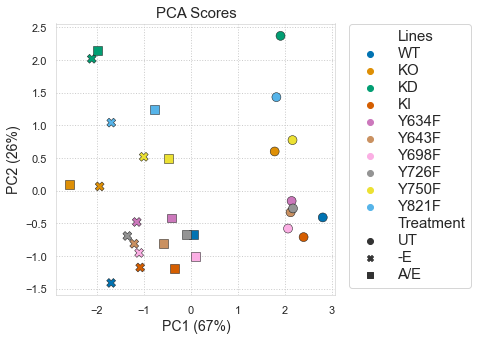

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Lines", style="Treatment", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
plt.savefig("PCA_phenotyes_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

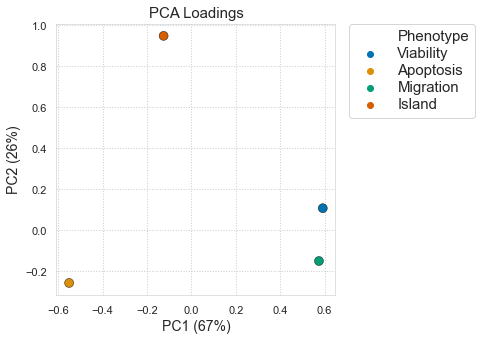

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Phenotype", ax=ax, s=80, markers=["o", "X", "d"], **{'linewidth':.5, 'edgecolor':"k"})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15)
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
plt.savefig("PCA_phenotyes_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [23]:
from scipy.stats import zscore

In [24]:
y = y_ae.drop("Treatment", axis=1).set_index("Lines")
y.iloc[:, :] = zscore(y.iloc[:, :])

# 0-. Final X and Y data sets to model

If dropping "WT", run:

In [25]:
# x = X.drop("PC9 A", axis=1)
# d = x.select_dtypes(include=['float64']).T
# i = x.select_dtypes(include=['object'])
# y = y.drop("WT")
# lines = mut_lines

Else:

In [26]:
lines = all_lines

# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

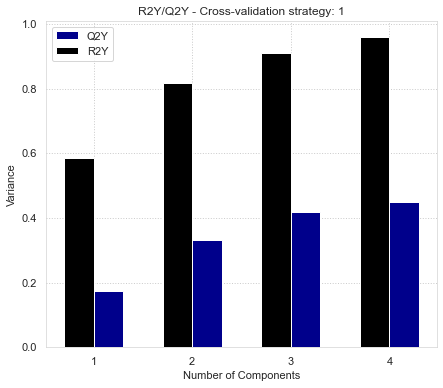

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p1, d, y, 1, 5)
plt.savefig("R2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

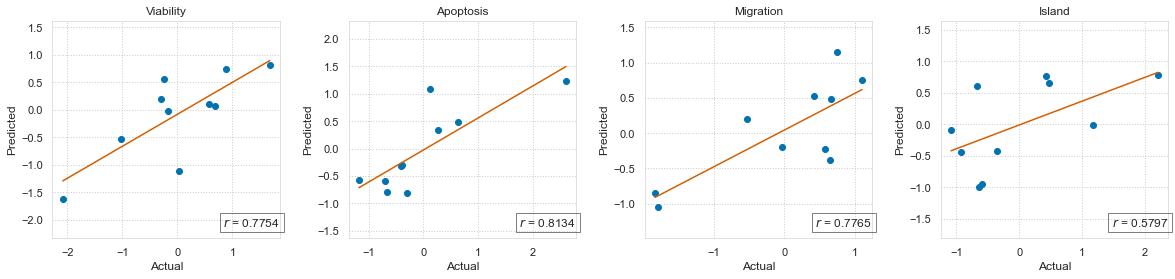

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p1, d, y, 1, y_pred="cross-validation")
plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
y_ = y.drop(["Island", "Apoptosis"], axis=1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p1.fit(d, y_), d, y_, 0, lines, cv=1, data="full", annotate=False)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("PLSR_unclustered_ScoresLoadings.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
from msresist.figures.figure3 import plotScoresLoadings_plotly

In [ ]:
X.head()

In [ ]:
y.index

In [ ]:
d_ = X[["Gene", "Position"] + list(X.columns[5:])].set_index(["Gene", "Position"]).T
d_.index = lines
fig = plotScoresLoadings_plotly(p1.fit(d_, y), d_, y, cv=1, loc=False)

In [ ]:
# import plotly.io as pio
# import chart_studio
# pio.write_html(fig, file="index.html", auto_open=True)

# chart_studio.tools.set_credentials_file(username="creixell", api_key="OHxZ0TtIByuOXRZ3V9Vb")

In [ ]:
# import chart_studio.plotly as py
# py.plot(fig, filename = 'AXLbr1_LoadingsScore_PLSRalone', auto_open=True)

# 2-Clustering and PLSR model

In [ ]:
ncl = 10

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [ ]:
# from sklearn.cluster import KMeans

# labels = KMeans(n_clusters=ncl).fit(d.T).labels_
# x_ = x.copy()
# x_["Cluster"] = labels
# c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [ ]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl).fit(d.T)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [ ]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p2 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p2, c1, y, 1, ncl+1)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

In [ ]:
# ig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p2, c1, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, lines, 1)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [ ]:
distance_method = "Binomial"
SeqWeight = 2
ncl = 7

MSC = MassSpecClustering(i, 
                         ncl, 
                         SeqWeight=SeqWeight, 
                         distance_method=distance_method, 
                         gmm_method="sklearn", 
                         n_runs=1).fit(d, y)
c2 = MSC.transform(d)

#### R2Y/Q2Y

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p3 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p3, c2, y, 1, ncl+1)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p3, c2, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.3-Random clustering and PLSR

In [ ]:
from random import choices
x__ = x.copy()
x__["Cluster"] = choices(list(np.arange(ncl)), k=x.shape[0])
c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p4 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [ ]:
import matplotlib.cm as cm
def plotclustersIndividually(centers, labels, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10), sharex=True, sharey=True)
    colors_ = cm.rainbow(np.linspace(0, 1, centers.shape[0]))
    l = [0, 5, 10]
    for i in range(centers.shape[0]):
        ax[i // ncols][i % ncols].plot(centers.iloc[i, :], label="cluster " + str(i + 1), color=colors_[i], linewidth=3)
        ax[i // ncols][i % ncols].set_xticks(np.arange(len(labels)))
        ax[i // ncols][i % ncols].set_xticklabels(labels, rotation=45)
        ax[i // ncols][i % ncols].set_ylabel("$log_{10}$ phospho signal")
        ax[i // ncols][i % ncols].legend()
        if i not in l:
            ax[i // ncols][i % ncols].set_ylabel("")

In [ ]:
q = pd.read_csv("members_Binomial_6CL_2W_4Ph_WithWT.csv")

In [ ]:
centers = []
for i in range(6):
    string = "C" + str(i+1)
    currC = q.loc[:, q.columns.str.contains(string)]
    currP = []
    for i in range(currC.shape[0]):
        try:
            currP.append(X.loc[currC.iloc[i, 1], currC.iloc[i, 2]])
        except:
            break
    centers.append((pd.concat([pd.DataFrame(currP)]).reset_index(drop=True).mean()))
        

In [ ]:
centers = pd.DataFrame(centers)

In [ ]:
plotclustersIndividually(centers, lines, 2, 3)
plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

#### R2Y/Q2Y

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [ ]:
scores = MSclusPLSR_tuning(d, i, y, "PAM250")
scores = pd.DataFrame(scores)
hp = scores.sort_values(by="mean_test_scores", ascending=False)
hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))

In [ ]:
hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")